In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

In [40]:
dat_train = pd.read_csv('train.csv')
dat_test = pd.read_csv('test.csv')

print(dat_train.describe())
print(dat_train.info())

                 id           Age  Driving_License   Region_Code  \
count  1.150480e+07  1.150480e+07     1.150480e+07  1.150480e+07   
mean   5.752398e+06  3.838356e+01     9.980220e-01  2.641869e+01   
std    3.321149e+06  1.499346e+01     4.443120e-02  1.299159e+01   
min    0.000000e+00  2.000000e+01     0.000000e+00  0.000000e+00   
25%    2.876199e+06  2.400000e+01     1.000000e+00  1.500000e+01   
50%    5.752398e+06  3.600000e+01     1.000000e+00  2.800000e+01   
75%    8.628598e+06  4.900000e+01     1.000000e+00  3.500000e+01   
max    1.150480e+07  8.500000e+01     1.000000e+00  5.200000e+01   

       Previously_Insured  Annual_Premium  Policy_Sales_Channel       Vintage  \
count        1.150480e+07    1.150480e+07          1.150480e+07  1.150480e+07   
mean         4.629966e-01    3.046137e+04          1.124254e+02  1.638977e+02   
std          4.986289e-01    1.645475e+04          5.403571e+01  7.997953e+01   
min          0.000000e+00    2.630000e+03          1.000000e+00

In [3]:
print(dat_train)

                id  Gender  Age  Driving_License  Region_Code  \
0                0    Male   21                1         35.0   
1                1    Male   43                1         28.0   
2                2  Female   25                1         14.0   
3                3  Female   35                1          1.0   
4                4  Female   36                1         15.0   
...            ...     ...  ...              ...          ...   
11504793  11504793    Male   48                1          6.0   
11504794  11504794  Female   26                1         36.0   
11504795  11504795  Female   29                1         32.0   
11504796  11504796  Female   51                1         28.0   
11504797  11504797    Male   25                1         28.0   

          Previously_Insured Vehicle_Age Vehicle_Damage  Annual_Premium  \
0                          0    1-2 Year            Yes         65101.0   
1                          0   > 2 Years            Yes         58911

In [41]:
dat_train['Vehicle_Age'].replace({'1-2 Year' : 1 , '> 2 Years' : 2, '< 1 Year' : 0}, inplace = True)
dat_train['Vehicle_Damage'].replace({ 'Yes' : 1 , 'No' : 0}, inplace = True)
dat_train['Gender'].replace({ 'Male' : 1, 'Female' : 0 } , inplace = True)

dat_test['Vehicle_Age'].replace({'1-2 Year' : 1 , '> 2 Years' : 2, '< 1 Year' : 0}, inplace = True)
dat_test['Vehicle_Damage'].replace({ 'Yes' : 1 , 'No' : 0}, inplace = True)
dat_test['Gender'].replace({ 'Male' : 1, 'Female' : 0 } , inplace = True)

C:\Users\yingz\AppData\Local\Temp\ipykernel_28224\2306336287.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dat_train['Vehicle_Age'].replace({'1-2 Year' : 1 , '> 2 Years' : 2, '< 1 Year' : 0}, inplace = True)
C:\Users\yingz\AppData\Local\Temp\ipykernel_28224\2306336287.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_sil

In [42]:
scaler = StandardScaler()
dat_train[['Age', 'Region_Code', 'Annual_Premium' , 'Policy_Sales_Channel', 'Vintage' ]] = StandardScaler().fit_transform(dat_train[['Age', 'Region_Code', 'Annual_Premium' , 'Policy_Sales_Channel', 'Vintage' ]])


X = dat_train.drop(columns=['id', 'Response'])
y = dat_train['Response']

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.2, random_state = 42, stratify = y)

### XGBClassifier

In [37]:
xgb = XGBClassifier(objective='binary:logistic', scale_pos_weight= 7.13,
                           colsample_bytree = 0.6 , max_depth = 8, 
                           min_child_weight = 3, eta = 0.189999, subsample = 0.9,
                           tree_method = "hist", device = "cuda", max_bin =290)
xgb.fit(X_train, y_train)
pred = xgb.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, pred))
#0.812630216395244
#plt.plot(fpr, tpr)


0.8797431372254938


### Log Reg model

In [31]:
clf = LogisticRegression(n_jobs = 4, random_state=0, C = 10, class_weight = 'balanced')
clf.fit(X_train, y_train)
pred_clf = clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, pred_clf))

0.8364686181855943


### SVM model

In [35]:
sgd = SGDClassifier( loss = 'log_loss' , class_weight= 'balanced', random_state= 0 , n_jobs= 6)
sgd.fit(X_train, y_train)
pred_sgd = sgd.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, pred_sgd))

0.8363738373865635


## Fine tuning the XGB

In [12]:
from sklearn.model_selection import RandomizedSearchCV

In [17]:
param_grid = {
    #'max_depth': np.arange(4,9,1),
    #'eta': np.arange(0.01 , 0.2, 0.02),
    #'min_child_weight':range(1,6,2),
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    #'colsample_bytree':[i/10.0 for i in range(6,10)],
}

fine_tuned = XGBClassifier(objective='binary:logistic', scale_pos_weight= 7.13, 
                           device="cuda" , colsample_bytree = 0.6 , max_depth = 8, 
                           min_child_weight = 3, eta = 0.189999, subsample = 0.9,
                           eval_metric = 'AUC')

grid_acc = RandomizedSearchCV(fine_tuned, param_grid, n_iter = 200, cv = 5, scoring = 'roc_auc', verbose=1, n_jobs = 6)
grid_acc.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_ra...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=200, n_jobs=6,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'eta': array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19]),
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'max_depth': array([4, 5, 6, 7, 8]),
                                        'min_child_weight': range(1, 6, 2),
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   scoring='roc_auc', verbose=1)

In [18]:
#print(grid_acc.best_estimator_.get_params())
print(grid_acc.best_score_)
#{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.6, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 7.13, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'eta': 0.18999999999999997}


{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.6, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 7.13, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'eta': 0.18999999999999997}
0.8783942934167639


### Fine Tuning log reg

In [13]:
param_grid2 = {
    'C' : [10, 50, 100, 300, 500, 1000],
    
}

fine_tuned2 = LogisticRegression(random_state=0, class_weight = 'balanced')

grid_acc = RandomizedSearchCV(fine_tuned2, param_grid2, n_iter = 6, cv = 5, scoring = 'roc_auc', verbose=1, n_jobs = 6)
grid_acc.fit(X_train, y_train)
print(grid_acc.best_score_)
print(grid_acc.best_estimator_.get_params())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.8366549088161476
{'C': 10, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### Fine tuning SGD classifier

## Explanations

### Explaining XGBOOST

In [18]:
%pip install shap


   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
   ------------------------------- ------- 368.6/456.1 kB 11.6 MB/s eta 0:00:01
   ---------------------------------------- 456.1/456.1 kB 9.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [19]:
import shap


In [22]:
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

  2%|                   | 44365/2300960 [03:12<162:45]       

### Explaining log reg


LinearExplainer explainer: 2300961it [00:12, 36082.63it/s]                              


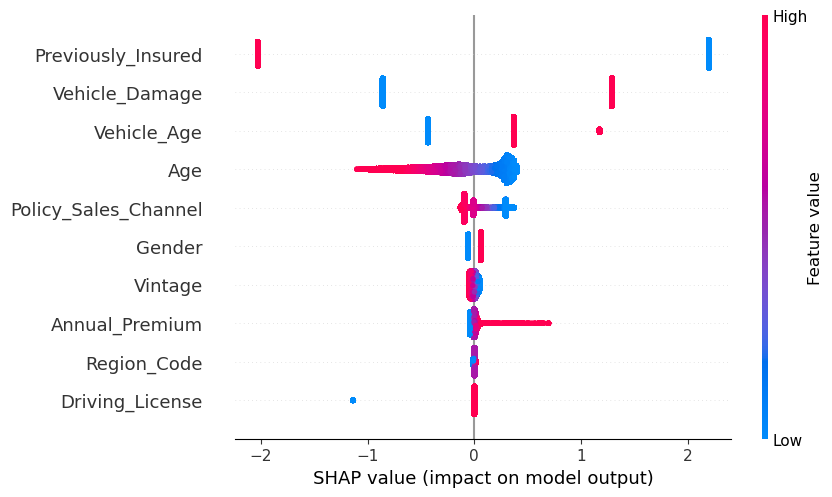

In [20]:
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)


### Explaining SGD

LinearExplainer explainer: 2300961it [00:14, 49110.79it/s]                              


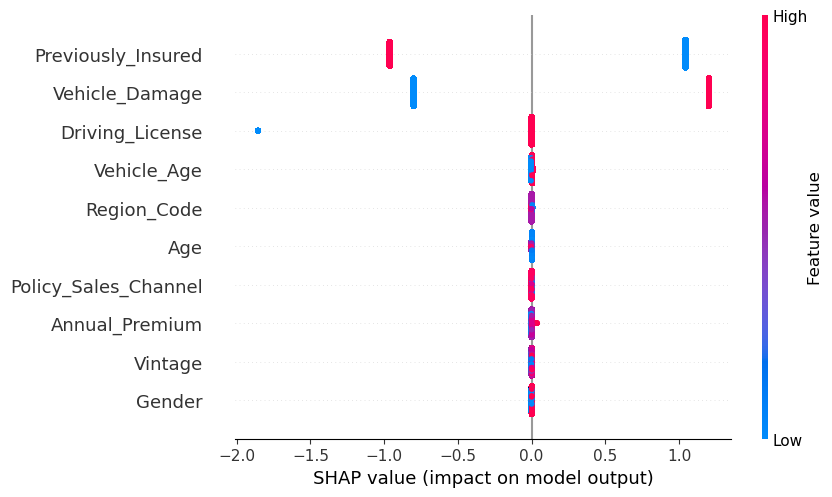

In [21]:
explainer = shap.Explainer(sgd, X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)


## export results

In [ ]:
iddf = dat_test['id']
dat_test = dat_test.drop(['id'], axis = 1)

In [46]:
xgb_test = XGBClassifier(objective='binary:logistic', scale_pos_weight= 7.13,
                           colsample_bytree = 0.6 , max_depth = 8, 
                           min_child_weight = 3, eta = 0.189999, subsample = 0.9,
                           tree_method = "hist", device = "cuda", max_bin =290)
xgb_test.fit(X, y)

xgb_t_pred = pd.DataFrame({ 'Target' : xgb_test.predict_proba(dat_test)[:, 1]}, index = iddf)

print(xgb_t_pred)

xgb_t_pred.to_csv('sol.csv')

            Target
id                
11504798  0.071823
11504799  0.342328
11504800  0.342328
11504801  0.006211
11504802  0.081290
...            ...
19174659  0.342328
19174660  0.005681
19174661  0.013187
19174662  0.272121
19174663  0.005681

[7669866 rows x 1 columns]
